In [1]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload the Kaggle API key (kaggle.json) that you downloaded
files.upload()


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.94G/1.96G [00:14<00:00, 146MB/s]
100% 1.96G/1.96G [00:14<00:00, 143MB/s]


In [ ]:
# Create a directory named 'bird-ds'
!mkdir -p bird-ds

# Move into the 'bird-ds' directory

# Unzip the dataset
!unzip 100-bird-species.zip -d bird-ds

Streaming output truncated to the last 5000 lines.
  inflating: bird-ds/train/WHITE TAILED TROPIC/120.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/121.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/122.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/123.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/124.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/125.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/126.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/127.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/128.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/129.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/130.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/131.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/132.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/133.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/134.jpg  
  inflating: bird-ds/train/WHITE TAILED TROPIC/135.jpg  
  inflating: bird-ds/train/WHITE TAIL

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np

# Load the CSV file
csv_path = 'bird-ds/birds.csv'
df = pd.read_csv(csv_path)
df

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
...,...,...,...,...,...
89880,524.0,valid/BLACK BREASTED PUFFBIRD/3.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89881,524.0,valid/BLACK BREASTED PUFFBIRD/4.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89882,524.0,valid/BLACK BREASTED PUFFBIRD/1.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89883,524.0,valid/BLACK BREASTED PUFFBIRD/2.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS


In [ ]:
df = df[(df['class id'] >= 0) & (df['class id'] <= 19)]
len(df)

1008

In [ ]:
def get_class_id_label_mapping(df):
    """
    Get a dictionary mapping class IDs to labels.

    Parameters:
    - df: DataFrame containing 'class id' and 'label' columns.

    Returns:
    - class_id_label_mapping: Dictionary mapping class IDs to labels.
    """
    class_id_label_mapping = dict(zip(df['class id'], df['labels']))
    return class_id_label_mapping

# Example usage:
# Assuming your DataFrame is named 'df' and contains 'class id' and 'label' columns
class_id_label_mapping = get_class_id_label_mapping(df)
print(class_id_label_mapping)

{0.0: 'ABBOTTS BABBLER', 1.0: 'ABBOTTS BOOBY', 2.0: 'ABYSSINIAN GROUND HORNBILL', 3.0: 'AFRICAN CROWNED CRANE', 4.0: 'AFRICAN EMERALD CUCKOO', 5.0: 'AFRICAN FIREFINCH'}


In [ ]:
print(df.columns)
print(df.head())

Index(['class id', 'filepaths', 'labels', 'data set', 'scientific name'], dtype='object')
   class id                      filepaths           labels data set  \
0       0.0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1       0.0  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER    train   
2       0.0  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER    train   
3       0.0  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER    train   
4       0.0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   

        scientific name  
0  MALACOCINCLA ABBOTTI  
1  MALACOCINCLA ABBOTTI  
2  MALACOCINCLA ABBOTTI  
3  MALACOCINCLA ABBOTTI  
4  MALACOCINCLA ABBOTTI  


In [ ]:
# Splitting into train and test DataFrames
train_df = df[df['data set'] == 'train']
test_df = df[df['data set'] == 'test']

print("Train DS Count:")
print(len(train_df))
print("Test DS Count:")
print(len(test_df))

Train DS Count:
948
Test DS Count:
30


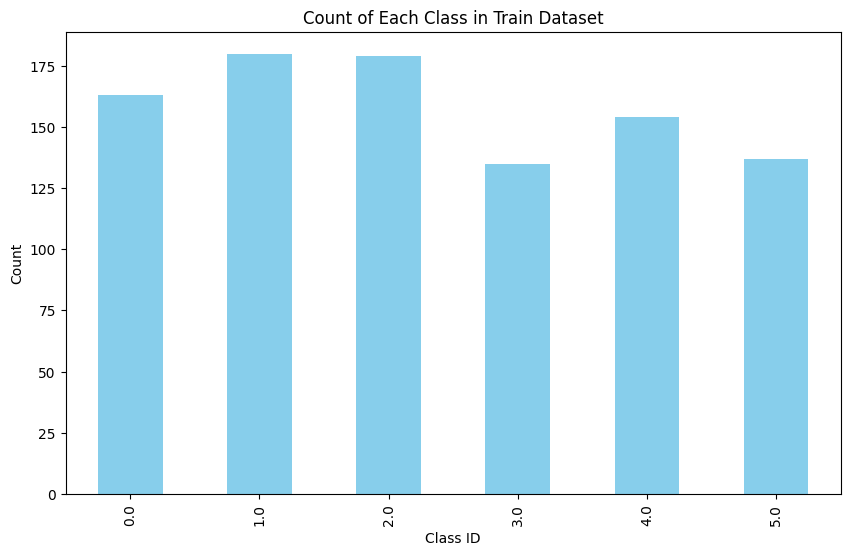

In [ ]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
train_df['class id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Count of Each Class in Train Dataset')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.show()


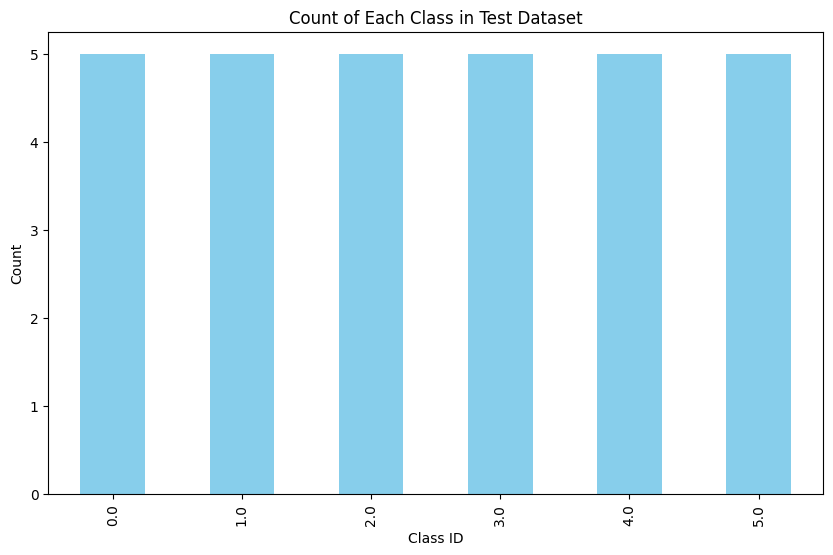

In [ ]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
test_df['class id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Count of Each Class in Test Dataset')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.show()

In [ ]:
# Assuming your DataFrame is named 'df'
distinct_values = train_df.nunique()

# Printing the number of distinct values for each feature
print("Number of distinct values for each feature:")
print(distinct_values)


Number of distinct values for each feature:
class id             6
filepaths          948
labels               6
data set             1
scientific name      6
dtype: int64


In [ ]:
# Assuming your DataFrame is named 'df'
null_values = train_df.isnull().sum()

# Printing the null values for each feature
print("Null values for each feature:")
print(null_values)

Null values for each feature:
class id           0
filepaths          0
labels             0
data set           0
scientific name    0
dtype: int64


In [ ]:
# Assuming your DataFrame is named 'df'
# Keep only 'class id' and 'filepaths' columns
train_df = train_df[['class id', 'filepaths']]

# If you want to modify the original DataFrame in-place, you can use the following line instead
# df.drop(df.columns.difference(['class id', 'filepaths']), axis=1, inplace=True)

# Printing the DataFrame with only 'class id' and 'filepaths'
print(train_df)


     class id                        filepaths
0         0.0    train/ABBOTTS BABBLER/001.jpg
1         0.0    train/ABBOTTS BABBLER/007.jpg
2         0.0    train/ABBOTTS BABBLER/008.jpg
3         0.0    train/ABBOTTS BABBLER/009.jpg
4         0.0    train/ABBOTTS BABBLER/002.jpg
..        ...                              ...
943       5.0  train/AFRICAN FIREFINCH/124.jpg
944       5.0  train/AFRICAN FIREFINCH/123.jpg
945       5.0  train/AFRICAN FIREFINCH/105.jpg
946       5.0  train/AFRICAN FIREFINCH/078.jpg
947       5.0  train/AFRICAN FIREFINCH/129.jpg

[948 rows x 2 columns]


In [ ]:
# Load and preprocess the images using VGG16
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Load VGG16 model pre-trained on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False)

# Extract features from the images using VGG16
def extract_features(img_path):
    img_array = preprocess_image(img_path)
    features = vgg_model.predict(img_array)
    return features.flatten()



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Apply feature extraction to all images
train_df['features'] = train_df['filepaths'].apply(lambda x: extract_features('bird-ds/' + x))
test_df['features'] = test_df['filepaths'].apply(lambda x: extract_features('bird-ds/' + x))



1/1 [==============================] - 0s 439ms/step


<ipython-input-18-f1a6c598e76a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['features'] = test_df['filepaths'].apply(lambda x: extract_features('bird-ds/' + x))


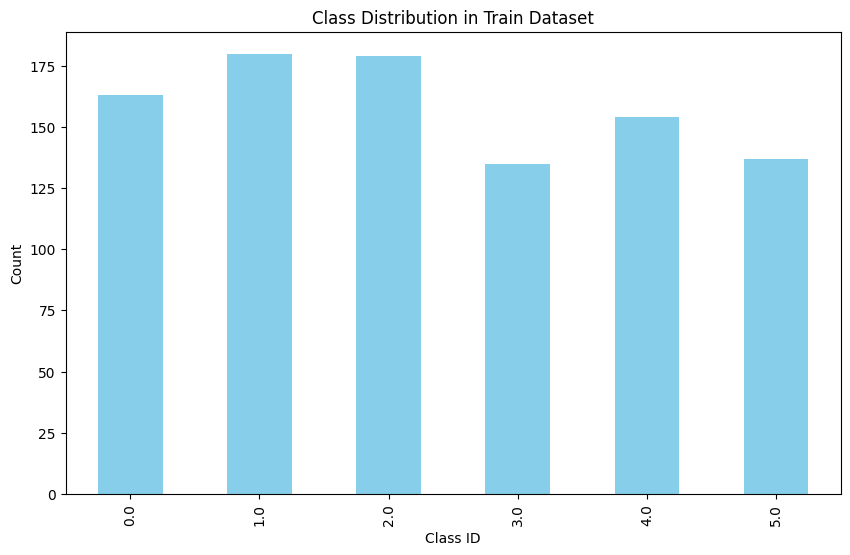

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
train_df['class id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Train Dataset')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.show()


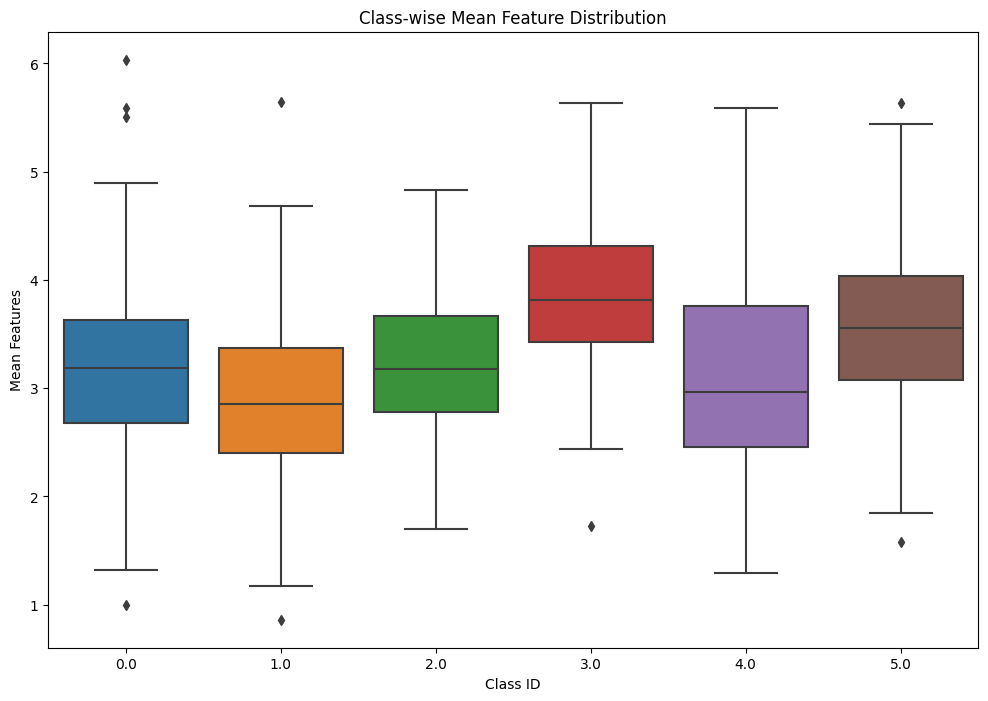

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(x='class id', y=train_df['features'].apply(lambda x: np.mean(x)), data=train_df)
plt.title('Class-wise Mean Feature Distribution')
plt.xlabel('Class ID')
plt.ylabel('Mean Features')
plt.show()


In [ ]:
# Prepare data for training
X = np.array(list(train_df['features']))
y = train_df['class id']

# Encode labels using LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize features using StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_std)

# Train the Support Vector Machine (SVM) classifier
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_pca, y_encoded)

SVC(random_state=42)

In [ ]:
# Prepare data for testing
X_test = np.array(list(test_df['features']))
y_test = test_df['class id']

# Encode labels using LabelEncoder
y_test_encoded = le.transform(y_test)

# Standardize features using the same scaler used for training
X_test_std = scaler.transform(X_test)

# Apply PCA for dimensionality reduction using the same PCA model used for training
X_test_pca = pca.transform(X_test_std)

# Make predictions on the test set
y_pred_test = svm_model.predict(X_test_pca)

# Evaluate the performance on the test set
accuracy_test = accuracy_score(y_test_encoded, y_pred_test)
print(f'Test Set Accuracy: {accuracy_test * 100:.2f}%')


Test Set Accuracy: 100.00%


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score, precision, and recall
f1 = f1_score(y_test_encoded, y_pred_test, average='weighted')
precision = precision_score(y_test_encoded, y_pred_test, average='weighted')
recall = recall_score(y_test_encoded, y_pred_test, average='weighted')

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Confusion Matrix:
[[5 0 0 0 0 0]
 [0 5 0 0 0 0]
 [0 0 5 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 0 5]]
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000


In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Step 1: Upload the image to Colab
uploaded = files.upload()

# Assuming the uploaded file is the first file in the list
img_path = list(uploaded.keys())[0]
img_array = extract_features(img_path)

# Step 3: Use the trained model to make predictions
img_features = pca.transform(scaler.transform(img_array.reshape(1, -1)))
prediction = svm_model.predict(img_features)

# Convert the encoded label back to the original class label
predicted_class = le.inverse_transform(prediction)[0]

# Print the predicted class
print(f'The uploaded image is classified as: {class_id_label_mapping[predicted_class]}')


Saving PAPASULA ABBOTTI.jpg to PAPASULA ABBOTTI (2).jpg
1/1 [==============================] - 0s 436ms/step
The uploaded image is classified as: AFRICAN EMERALD CUCKOO


In [ ]:
!pip install matplotlib scikit-learn mlxtend
from mlxtend.plotting import plot_decision_regions


ValueError: ignored

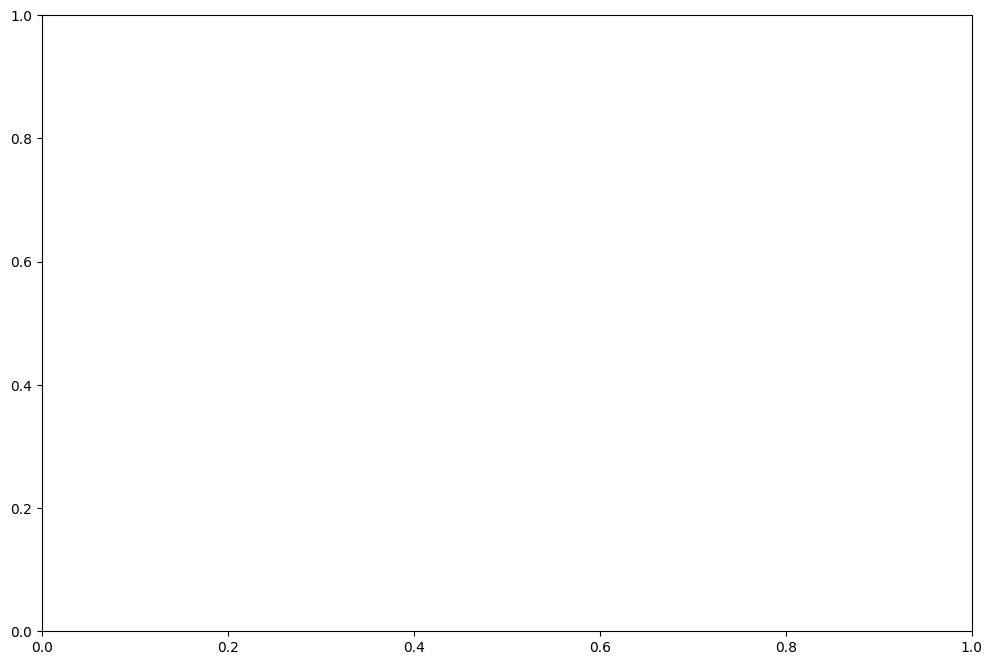

In [ ]:
plt.figure(figsize=(12, 8))
A=y.to_numpy()
plot_decision_regions(X, A.astype(int), clf=svm_model, legend=2,filler_feature_values=[0, 0])
plt.title(f'SVM Decision Boundary - Kernel: {kernel}, C: {C}')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.show()


In [ ]:
!pip install joblib
import joblib

# Assuming you have the following objects:
# - svm_model: Your trained Support Vector Machine (SVM) model
# - pca: The PCA object used for dimensionality reduction
# - scaler: The StandardScaler object used for feature scaling
# - le: The LabelEncoder object used for label encoding
# - class_id_label_mapping: The dictionary mapping class IDs to labels

# Save the trained SVM model
joblib.dump(svm_model, '/content/bird-classifcation-97-20/svm_model.joblib')

# Save the PCA object
joblib.dump(pca, '/content/bird-classifcation-97-20/pca_model.joblib')

# Save the StandardScaler object
joblib.dump(scaler, '/content/bird-classifcation-97-20/scaler_model.joblib')

# Save the LabelEncoder object
joblib.dump(le, '/content/bird-classifcation-97-20/label_encoder_model.joblib')

# Save the class_id_label_mapping dictionary
joblib.dump(class_id_label_mapping, '/content/bird-classifcation-97-20/class_id_label_mapping.joblib')


['/content/bird-classifcation-97-20/class_id_label_mapping.joblib']

In [ ]:
!zip -r /content/bird-classifcation-97-20.zip /content/bird-classifcation-97-20

updating: content/bird-classifcation-97-20/ (stored 0%)
  adding: content/bird-classifcation-97-20/svm_model.joblib (deflated 52%)
  adding: content/bird-classifcation-97-20/pca_model.joblib (deflated 7%)
  adding: content/bird-classifcation-97-20/label_encoder_model.joblib (deflated 38%)
  adding: content/bird-classifcation-97-20/class_id_label_mapping.joblib (deflated 48%)
  adding: content/bird-classifcation-97-20/scaler_model.joblib (deflated 7%)
